In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Lambda, Layer
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import layers,mixed_precision
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, EarlyStopping

ModuleNotFoundError: No module named 'tensorflow.keras.saving'

In [2]:
mixed_precision.set_global_policy('mixed_float16')
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.17.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def setup_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU setup complete.")
setup_gpu()

✅ GPU setup complete.


In [4]:
# # Load and preprocess .mp4 videos
# def load_video(video_path, max_frames=30, target_size=(224, 224)):
#     cap = cv2.VideoCapture(video_path.numpy().decode("utf-8"))
#     frames = []
    
#     for _ in range(max_frames):
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frame = cv2.resize(frame, target_size)  # Resize for MoViNet
#         frame = frame / 255.0  # Normalize pixels
#         frames.append(frame)

#     cap.release()

#     # Pad if fewer than max_frames
#     while len(frames) < max_frames:
#         frames.append(np.zeros(target_size + (3,)))

#     return np.array(frames, dtype=np.float32)

In [5]:
def load_video(video_path, max_frames=30, target_size=(224, 224), augment=False):
    cap = cv2.VideoCapture(video_path.numpy().decode("utf-8"))
    frames = []

    for _ in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = frame / 255.0  # Normalize to [0,1]

        if augment:
            # Horizontal flip
            if np.random.rand() < 0.5:
                frame = cv2.flip(frame, 1)

            # Brightness adjustment
            if np.random.rand() < 0.5:
                factor = 0.8 + 0.4 * np.random.rand()  # [0.8, 1.2]
                frame = np.clip(frame * factor, 0, 1)

        frames.append(frame)

    cap.release()

    # Pad if fewer than max_frames
    while len(frames) < max_frames:
        frames.append(np.zeros(target_size + (3,), dtype=np.float32))

    # Random temporal jitter: select a slice
    if augment and len(frames) > max_frames:
        start = np.random.randint(0, len(frames) - max_frames)
        frames = frames[start:start + max_frames]
    else:
        frames = frames[:max_frames]

    return np.array(frames, dtype=np.float32)


In [6]:
def get_class_names(data_dir):
    class_names = sorted([
        folder for folder in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, folder))
    ])
    print("Label Mapping (index → class):")
    for idx, name in enumerate(class_names):
        print(f"{idx:2d} → {name}")
    return class_names


def create_dataset(directory, batch_size, augment=False):
    video_paths = []
    labels = []

    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for f in os.listdir(class_dir):
            if f.endswith(".mp4"):
                video_paths.append(os.path.join(class_dir, f))
                labels.append(idx)

    dataset = tf.data.Dataset.from_tensor_slices((video_paths, labels))

    def _parse_function(filename, label):
        # video = tf.py_function(load_video, [filename], tf.float32)
        video = tf.py_function(lambda f: load_video(f, augment=augment), [filename], tf.float32)
        video.set_shape([30, 224, 224, 3])
        return video, label

    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [7]:
class_names = get_class_names("/kaggle/input/capstone-dataset/split_data/train")
num_classes = len(class_names)

train_data = create_dataset("/kaggle/input/capstone-dataset/split_data/train", batch_size=16, augment=True)
val_data = create_dataset("/kaggle/input/capstone-dataset/split_data/val", batch_size=16, augment=False)
test_data = create_dataset("/kaggle/input/capstone-dataset/split_data/test", batch_size=16, augment=False)

Label Mapping (index → class):
 0 → Ball out of play
 1 → Clearance
 2 → Corner
 3 → Direct free-kick
 4 → Foul
 5 → Goal
 6 → Indirect free-kick
 7 → Kick-off
 8 → Offside
 9 → Penalty
10 → Red card
11 → Shots off target
12 → Shots on target
13 → Substitution
14 → Throw-in
15 → Yellow card
16 → Yellow-_red card


In [8]:
# Flatten all training labels
train_labels = []
for idx, cls in enumerate(class_names):
    count = len(os.listdir(os.path.join("/kaggle/input/capstone-dataset/split_data/train", cls)))
    train_labels += [idx] * count

# Compute balanced class weights
weights = compute_class_weight(class_weight="balanced", classes=np.arange(len(class_names)), y=train_labels)
class_weights = {i: w for i, w in enumerate(weights)}

In [9]:
class SaveEveryNEpochs(Callback):
    def __init__(self, save_dir='checkpoints', interval=5):
        super().__init__()
        self.save_dir = save_dir
        self.interval = interval
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            file_path = os.path.join(self.save_dir, f'model_epoch_{epoch + 1}.h5')
            self.model.save(file_path)
            print(f"Model saved at: {file_path}")


In [10]:
# Load MoViNet-A3 from TensorFlow Hub
model_id = 'a3'
mode = 'base'
version = '3'
model_url = f"https://tfhub.dev/tensorflow/movinet/{model_id}/{mode}/kinetics-600/classification/{version}"



# class MoViNetFeatureExtractor(tf.keras.layers.Layer):
#     def __init__(self, hub_url, trainable=False):
#         super().__init__()
#         self.movinet_layer = hub.KerasLayer(hub_url, trainable=trainable)

#     def call(self, inputs):
#         # Expecting input of shape (None, 30, 224, 224, 3)
#         return self.movinet_layer({'image': inputs})

@register_keras_serializable()
class MoViNetFeatureExtractor(Layer):
    def __init__(self, hub_url, **kwargs):
        super().__init__(**kwargs)
        self.hub_url = hub_url
        self.feature_extractor = hub.KerasLayer(hub_url, trainable=True)

    def call(self, inputs):
        return self.feature_extractor({"image": inputs})

    def get_config(self):
        config = super().get_config()
        config.update({
            'hub_url': self.hub_url,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
lr_callback = ReduceLROnPlateau (
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

save_callback = SaveEveryNEpochs(save_dir='/kaggle/working/checkpoints', interval=5)

earlystop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,             
    restore_best_weights=True,
    verbose=1
)


In [11]:
# inputs = keras.Input(shape=(30, 224, 224, 3), name="input_video")

# x = MoViNetFeatureExtractor(model_url,trainable=True)(inputs)

# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.2)(x)

# outputs = layers.Dense(num_classes, activation='softmax', dtype = 'float32')(x)


# model = keras.Model(inputs=inputs, outputs=outputs)
# model.summary()

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )


In [12]:
inputs = tf.keras.Input(shape=(30, 224, 224, 3), name='input_video')


x = MoViNetFeatureExtractor(model_url, trainable=True)(inputs)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(17, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Load weights from the .h5 file
# model = load_model('/kaggle/input/capstone_model_90/keras/default/1/movinet_final_model (1).keras',
#                    custom_objects={'MoViNetFeatureExtractor': MoViNetFeatureExtractor})
model.load_weights('/kaggle/input/capstone_model_140/keras/default/1/movinet_140_model.keras')

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [13]:
model.fit(
    train_data,
    validation_data=val_data,
    epochs=60,
    class_weight=class_weights,
    callbacks=[lr_callback,save_callback]
)

model.save("movinet_final_model.keras")

Epoch 1/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 1052s 5s/step - accuracy: 0.2856 - loss: 2.2839 - val_accuracy: 0.3269 - val_loss: 2.1592 - learning_rate: 1.0000e-05
Epoch 2/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.3045 - loss: 2.1047 - val_accuracy: 0.3191 - val_loss: 2.1612 - learning_rate: 1.0000e-05
Epoch 3/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.3130 - loss: 1.9903 - val_accuracy: 0.3308 - val_loss: 2.1664 - learning_rate: 1.0000e-05
Epoch 4/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3333 - loss: 1.9806
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
153/153 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.3333 - loss: 1.9832 - val_accuracy: 0.3308 - val_loss: 2.1720 - learning_rate: 1.0000e-05
Epoch 5/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3185 - loss: 1.9640Model saved at: /kaggle/working/checkpoints/model_epoch_5.h5
153/153 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.3185 - loss: 1.9662 

In [14]:
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc * 100:.2f}%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - accuracy: 0.2861 - loss: 2.3006
Test Accuracy: 32.22%


1/1 ━━━━━━━━━━━━━━━━━━━━ 149s 149s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 73

<Figure size 1200x800 with 0 Axes>

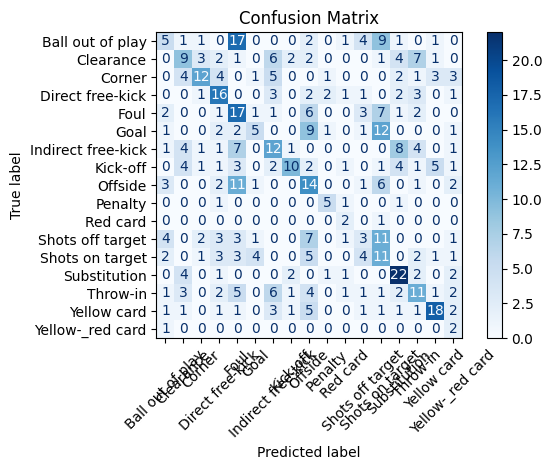

In [15]:
y_true = []
y_pred = []

for x_batch, y_batch in test_data:
    preds = model.predict(x_batch)
    y_true.extend(y_batch.numpy())  
    y_pred.extend(np.argmax(preds, axis=1))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot and save confusion matrix
plt.figure(figsize=(12, 8))
disp.plot(xticks_rotation=45, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()